# Water Quality Parameters - Statistics

This notebook aims at computing the descriptive statistics for the WQP maps, or any raster, by defining specific features from which these statistics are requested. In addition, the analysis of the WQP maps will consider de extraction of sampling data inside the pixels to review the estimates.

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

Import the libraries needed for the analysis

In [2]:
# Data
import math
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats, point_query

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show_hist

# Import custom libraries
import wqpFunctions as wqp

Define the working directory for the WQP processing

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in',
    'out': './out',
    'vector': './vector',
}

## Lakes sampling points

Import the vector files for data extraction of the WQP maps

In [4]:
# Layer dataset
gdf_lakes = gpd.read_file(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'))
# Buoy position in the lake
gdf_buoy = gpd.read_file(os.path.join(cwd['vector'],'boa_sample_points','boa_sample_points.shp'))
# Random sampling points
gdf_sample = gpd.read_file(os.path.join(cwd['vector'],'random_points','random_points.shp'))

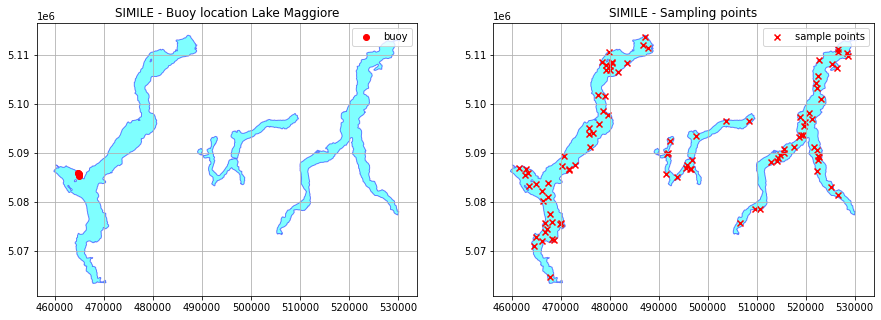

In [5]:
# Data Visualization of the lakes and buoy

# Plot settings
f, axs = plt.subplots(1, 2, figsize=(15,15))

# Sampling buoy
gdf_lakes.plot(ax=axs[0],color='cyan', edgecolor='blue', alpha=0.5)
gdf_buoy.plot(ax=axs[0], label='buoy', marker='o', color='red')
axs[0].set_title('SIMILE - Buoy location Lake Maggiore')
axs[0].legend()
axs[0].grid()

# Random sampling points
gdf_lakes.plot(ax=axs[1],color='cyan', edgecolor='blue', alpha=0.5)
gdf_sample.plot(ax=axs[1], label='sample points', marker ='x', color='red')
axs[1].set_title('SIMILE - Sampling points')
axs[1].legend()
axs[1].grid()

## WQP Map example

Read a WQP map and take advantage of the wqp library functions

In [6]:
#Import the sample dataset
src = wqp.wqp('./in\\S3A_CHL_IT_20200102T094306_L1.tif')
src.readWQP()

Use the attributes and methods for the [rasterio](https://rasterio.readthedocs.io/en/latest/) objects.

In [7]:
src.image.crs

CRS.from_epsg(32632)

In [8]:
src.image.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 236, 'height': 169, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(300.0, 0.0, 459734.0911791796,
       0.0, -300.0, 5114064.250351359), 'tiled': False, 'interleave': 'band'}

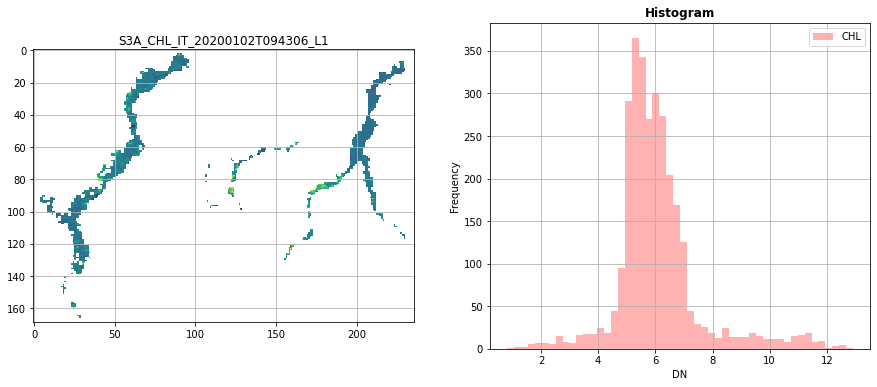

In [9]:
# Data visualization of sample WQP
f, axs = plt.subplots(1, 2, figsize=(15,6))

#PLot WQP
axs[0].imshow(src.image.read(1), cmap='viridis')
axs[0].grid()
axs[0].set_title('S3A_CHL_IT_20200102T094306_L1')

#Histogram of values for the bands in the WQP map (single-band)
axs[1] = show_hist(
    src.image, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram", label='CHL')

Compute the descriptive statistics using the [rasterstats](https://pythonhosted.org/rasterstats/) library. Update the wqp object computing the statistics using reference polygon features within the image.

### Descriptive statistics - polygons

In [10]:
src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std",0)

Present the contents for the example raster layer

In [11]:
src.__dict__

{'path': './in\\S3A_CHL_IT_20200102T094306_L1.tif',
 'name': 'S3A_CHL_IT_20200102T094306_L1',
 'sensor': 'S3A',
 'typology': 'CHL',
 'crs': 'IT',
 'date': datetime.datetime(2020, 1, 2, 9, 43, 6),
 'image': <open DatasetReader name='./in\S3A_CHL_IT_20200102T094306_L1.tif' mode='r'>,
 'stats': {'Maggiore': {'min': 0.8147814869880676,
   'max': 11.643258094787598,
   'mean': 6.0470227730938415,
   'count': 1705,
   'std': 1.2821317838447261,
   'median': 5.95936918258667},
  'Como': {'min': 1.4740662574768066,
   'max': 12.610143661499023,
   'mean': 5.98890732546706,
   'count': 1017,
   'std': 1.5203794679994693,
   'median': 5.543182849884033},
  'Lugano': {'min': 1.2527921199798584,
   'max': 12.913575172424316,
   'mean': 6.435019127408364,
   'count': 266,
   'std': 2.290654442793124,
   'median': 6.254514694213867}}}

### Extract sample points

Extract information of the raster dataset using sampling points for the first band of a raster.

In [12]:
gdf_sample.head()

,fid,id,geometry
0,1.0,0,POINT (497652.353 5093506.819)
1,2.0,1,POINT (522545.439 5088579.415)
2,3.0,2,POINT (467520.010 5080956.243)
3,4.0,3,POINT (467932.633 5064720.093)
4,5.0,4,POINT (491544.431 5085740.736)


In [13]:
src.extractSamplePoints(gdf_sample[0:5])

In [14]:
src.samplePoint

,x,y,row,col,CHL
0,497652.353120,5.093507e+06,68,126,6.332101
1,522545.438963,5.088579e+06,84,209,4.924937
2,467520.010459,5.080956e+06,110,25,5.147575
3,467932.633429,5.064720e+06,164,27,10.166382
4,491544.431452,5.085741e+06,94,106,NaN


### Create a new dataset

In [15]:
t = src.image.read(1)
t = np.nan_to_num(t)
t[t<=0] = np.nan

In [16]:
src.writeWQP(os.path.join(cwd['out'],'nanImages'),t)

### Export statistics

Create, or update, a dataset containing the information about the statistics of the processed wqp maps.

In [17]:
src.stats

{'Maggiore': {'min': 0.8147814869880676,
  'max': 11.643258094787598,
  'mean': 6.0470227730938415,
  'count': 1705,
  'std': 1.2821317838447261,
  'median': 5.95936918258667},
 'Como': {'min': 1.4740662574768066,
  'max': 12.610143661499023,
  'mean': 5.98890732546706,
  'count': 1017,
  'std': 1.5203794679994693,
  'median': 5.543182849884033},
 'Lugano': {'min': 1.2527921199798584,
  'max': 12.913575172424316,
  'mean': 6.435019127408364,
  'count': 266,
  'std': 2.290654442793124,
  'median': 6.254514694213867}}

In [18]:
# New dictionary for the dataset to become a DataFrame
df_temp = pd.DataFrame(src.stats)
df_temp.head()

,Maggiore,Como,Lugano
min,0.814781,1.474066,1.252792
max,11.643258,12.610144,12.913575
mean,6.047023,5.988907,6.435019
count,1705.000000,1017.000000,266.000000
std,1.282132,1.520379,2.290654


In [19]:
df = wqp.wqp.exportWQPFormatEstimates(src)

In [20]:
df

,name,path,sensor,typology,crs,date,min_Maggiore,max_Maggiore,mean_Maggiore,count_Maggiore,...,mean_Como,count_Como,std_Como,median_Como,min_Lugano,max_Lugano,mean_Lugano,count_Lugano,std_Lugano,median_Lugano
0,S3A_CHL_IT_20200102T094306_L1,./in\S3A_CHL_IT_20200102T094306_L1.tif,S3A,CHL,IT,2020-01-02 09:43:06,0.814781,11.643258,6.047023,1705,...,5.988907,1017,1.520379,5.543183,1.252792,12.913575,6.435019,266,2.290654,6.254515


In [36]:
# Export the statistics result to a file (append data if existing)
out_file = os.path.join(cwd['out'],'lakesStats','lakesStats.csv')
if os.path.exists(out_file):
    df.to_csv(os.path.join(cwd['out'],'lakesStats','lakesStats.csv'),mode='a', header=False)
else:
    df.to_csv(os.path.join(cwd['out'],'lakesStats','lakesStats.csv')) 

False
